<a href="https://colab.research.google.com/github/paolominguzzi/AI_Supply_Chain/blob/master/Limon_Market_Analisis_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from xgboost import XGBRegressor

In [ ]:
# Step 2: Uploading the documents
from google.colab import files
uploaded = files.upload()

Saving series-históricas-de-frutas-y-hortalizas_mensual_Limon.xlsx to series-históricas-de-frutas-y-hortalizas_mensual_Limon (1).xlsx


In [ ]:
# Step 3: Loading the data
# Assuming that the uploaded files are in Excel format
data_files = {}
for filename in uploaded.keys():
    data_files[filename] = pd.read_excel(filename)

In [ ]:
# Example: Display the first few rows of one of the uploaded files
for key in data_files:
    print(f"Displaying data from {key}:")
    print(data_files[key].head())

Displaying data from series-históricas-de-frutas-y-hortalizas_mensual_Limon (1).xlsx:
     Fecha                              Mercado  Variedad / Tipo      Calidad  \
0  07/2021     Agrícola del Norte S.A. de Arica    Sutil De Gase      Primera   
1  07/2021     Agrícola del Norte S.A. de Arica  Sin especificar  2a amarillo   
2  07/2021     Agrícola del Norte S.A. de Arica  Sin especificar  2a amarillo   
3  07/2021     Agrícola del Norte S.A. de Arica  Sin especificar  2a amarillo   
4  07/2021  Comercializadora del Agro de Limarí  Sin especificar  1a amarillo   

              Procedencia  Volumen  Precio mínimo  Precio máximo  \
0                    Perú   1020.0   32016.560849   35218.216934   
1  Provincia de Melipilla    270.0   11739.405560   12806.624340   
2    Región Metropolitana    740.0   11739.405560   12806.624340   
3      Región de Coquimbo    670.0    9604.968255   12806.624340   
4     Provincia de Limarí   5240.0    3201.656085    3735.265348   

   Precio promedi

In [ ]:
# Step 4: Preprocessing the data
# Combine the data from different markets if necessary, or process them separately
limon_data = data_files['series-históricas-de-frutas-y-hortalizas_mensual_Limon (1).xlsx']

In [ ]:
# Step 4: Preprocessing the data
# Combine the data from different markets if necessary, or process them separately
limon_data = data_files['series-históricas-de-frutas-y-hortalizas_mensual_Limon (1).xlsx']

# Assuming the dataframe has 'Fecha', 'Precio' and 'Volumen'
# Convert the 'Fecha' column to datetime, handling errors
limon_data['Fecha'] = pd.to_datetime(limon_data['Fecha'], errors='coerce')

# Check for and handle any missing values (NaT) introduced by the conversion
print(limon_data.isnull().sum())

Fecha                         1
Mercado                       1
Variedad / Tipo               1
Calidad                       1
Procedencia                   1
Volumen                       1
Precio mínimo                 1
Precio máximo                 1
Precio promedio               1
Unidad de comercialización    1
dtype: int64


<ipython-input-14-2d3aa429c93b>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  limon_data['Fecha'] = pd.to_datetime(limon_data['Fecha'], errors='coerce')


In [ ]:
# Sort by date
limon_data = limon_data.sort_values('Fecha')


In [ ]:
# Normalize the data
scaler = MinMaxScaler()
limon_data[['Precio promedio', 'Volumen']] = scaler.fit_transform(limon_data[['Precio promedio', 'Volumen']])

In [ ]:
# Step 5: Train/Test Split
train_size = int(len(limon_data) * 0.8)
train, test = limon_data[:train_size], limon_data[train_size:]

In [ ]:
# Step 6: LSTM Model for Stock Prediction
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step)]  # Removed the second index ", 0"
        X.append(a)
        Y.append(data[i + time_step])  # Removed the second index ", 0"
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train['Volumen'].values, time_step)
X_test, y_test = create_dataset(test['Volumen'].values, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

4381/4381 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 0.0109


In [ ]:
# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
# Reshape the predictions to be 2D arrays before inverse transforming
train_predict_2d = train_predict.reshape(-1, 1)
test_predict_2d = test_predict.reshape(-1, 1)

In [ ]:
num_features = 7

In [ ]:
# Reshape the predictions to match the original number of features (assuming it was 1)
train_predict_2d = train_predict.reshape(-1, 1)
test_predict_2d = test_predict.reshape(-1, 1)

In [ ]:
# Step 7: ARIMA Model for Price Prediction
arima_model = ARIMA(train['Precio promedio'], order=(5,1,0))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

In [ ]:
# Step 8: Prophet Model for Seasonality and Trend Prediction
prophet_df = limon_data[['Fecha', 'Precio promedio']].rename(columns={'Fecha': 'ds', 'Precio promedio': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6rwtrehi/i6aw2_s6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6rwtrehi/1tqbx_5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6723', 'data', 'file=/tmp/tmp6rwtrehi/i6aw2_s6.json', 'init=/tmp/tmp6rwtrehi/1tqbx_5e.json', 'output', 'file=/tmp/tmp6rwtrehi/prophet_modelrura1hoq/prophet_model-20240901050242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:02:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:02:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Step 9: XGBoost for Price and Volume Prediction
X = limon_data[['Volumen']].values
y = limon_data['Precio promedio'].values

# Check for and handle invalid values in 'y'
y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)  # Replace NaN and infinities with 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

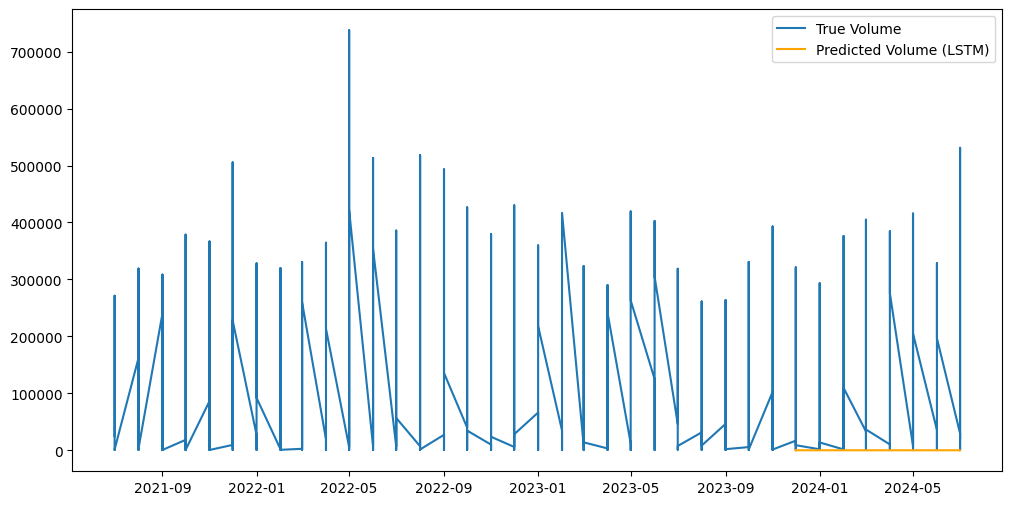

In [ ]:
# Step 10: Visualizations
import matplotlib.pyplot as plt  # Make sure you import matplotlib.pyplot

plt.figure(figsize=(12, 6))

# Replace 'another_feature' with the actual name of the second feature the scaler was fit on
transformed_volumen = scaler.inverse_transform(limon_data[['Volumen', 'Precio promedio']].values)[:, 0]
plt.plot(limon_data['Fecha'], transformed_volumen, label='True Volume')

plt.plot(limon_data['Fecha'][-len(test_predict):], test_predict, label='Predicted Volume (LSTM)', color='orange')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


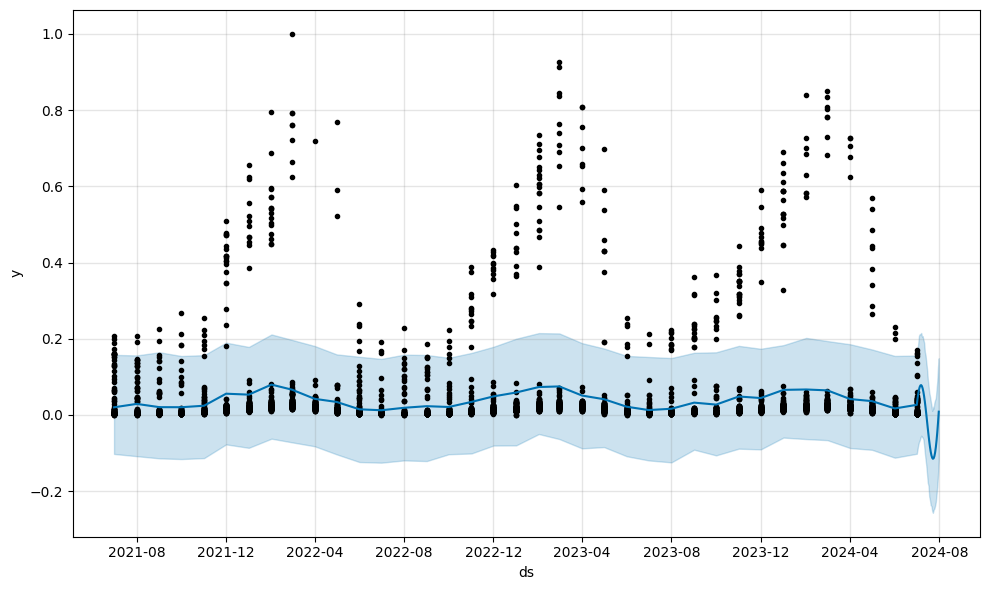

In [ ]:
# Prophet Prediction
prophet_model.plot(forecast)
plt.show()

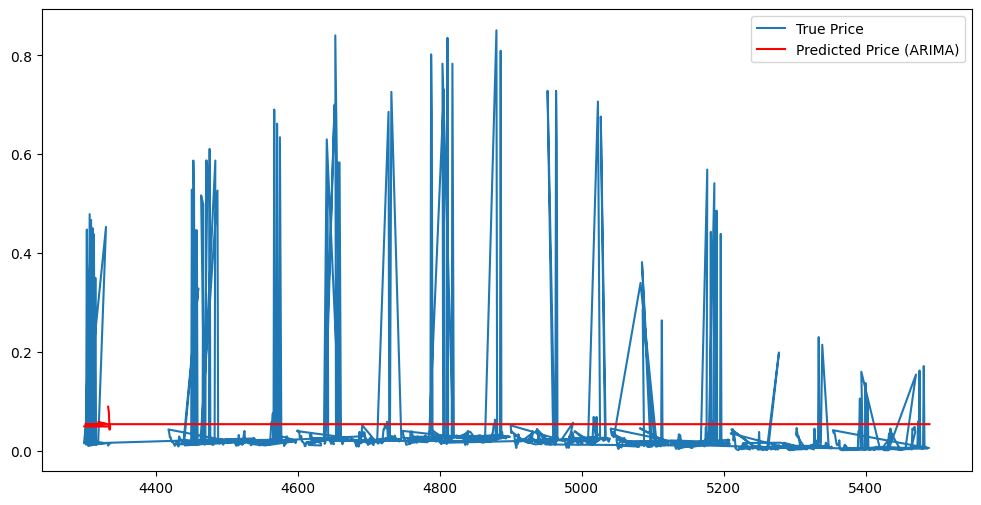

In [ ]:
# ARIMA Prediction
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Precio promedio'], label='True Price')
plt.plot(test.index, arima_predictions, label='Predicted Price (ARIMA)', color='red')
plt.legend()
plt.show()

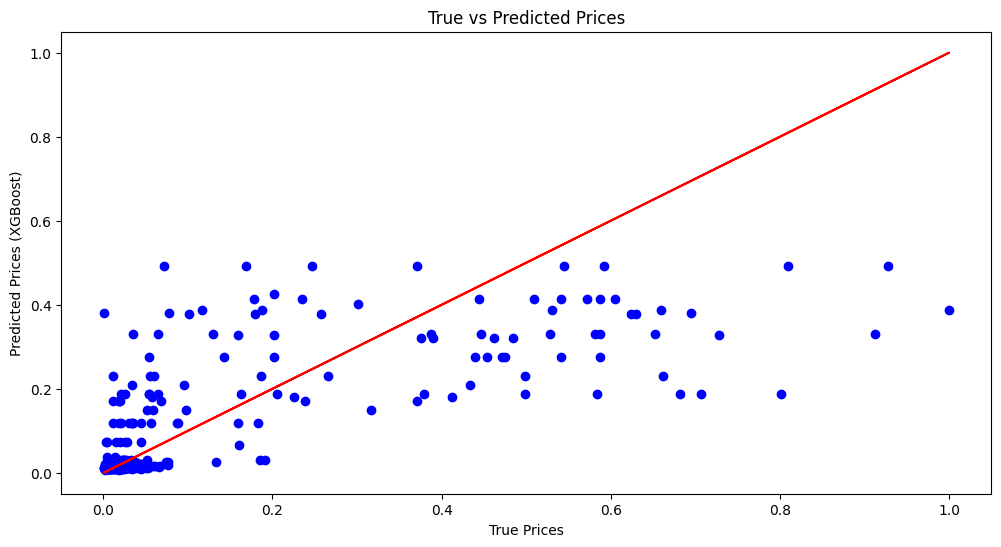

In [ ]:
# XGBoost Prediction
plt.figure(figsize=(12, 6))
plt.scatter(y_test, xgb_predictions, color='blue')
plt.plot(y_test, y_test, color='red')
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices (XGBoost)')
plt.title('True vs Predicted Prices')
plt.show()

In [ ]:
# Assuming that you have already trained the models and made predictions as described earlier
# AND that 'limon_data' is the DataFrame containing the 'Volumen' column
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# Fit the scaler on the 'Volumen' column only
scaler = MinMaxScaler() # Reinitialize the scaler
scaler.fit(limon_data['Volumen'].values.reshape(-1, 1))

MinMaxScaler()

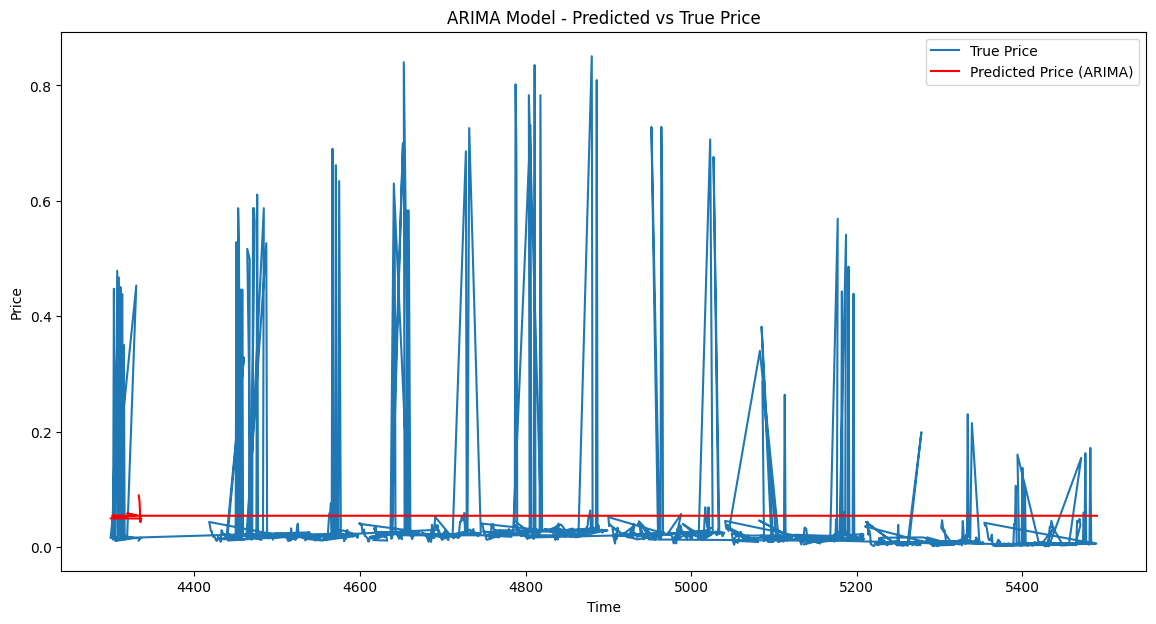

In [ ]:
# 2. ARIMA Model Predictions for Price
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Precio promedio'], label='True Price')
plt.plot(test.index, arima_predictions, label='Predicted Price (ARIMA)', color='red')
plt.title('ARIMA Model - Predicted vs True Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


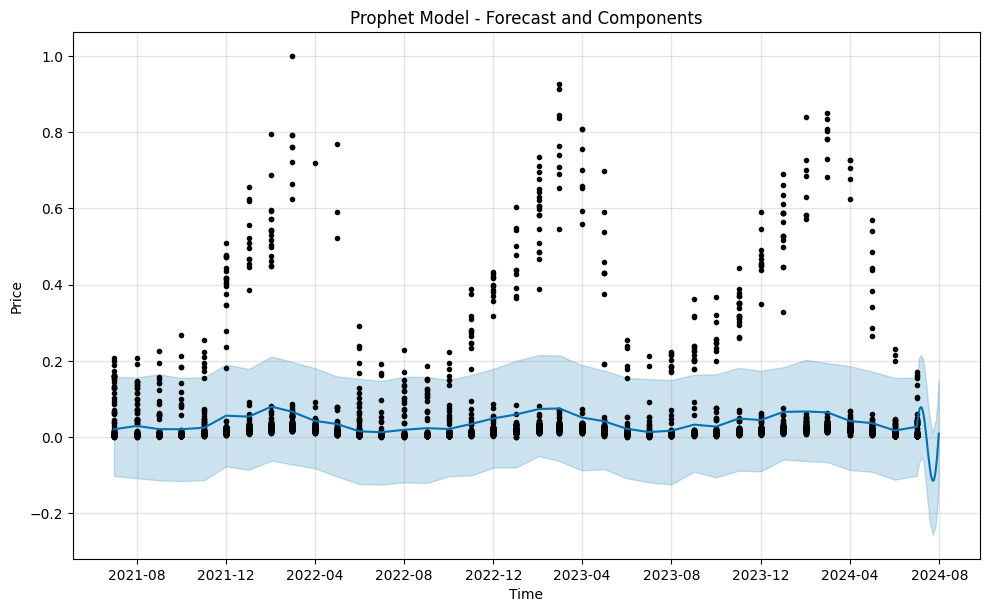

In [ ]:
# 3. Prophet Model Predictions for Trend and Seasonality
prophet_model.plot(forecast)
plt.title('Prophet Model - Forecast and Components')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

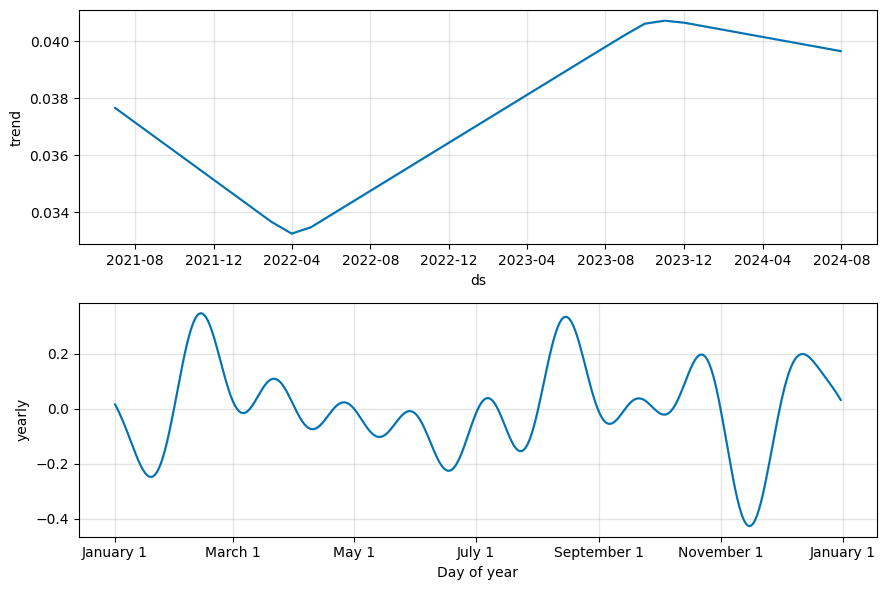

In [ ]:
# Optional: Plot the components of the Prophet model to see trend and seasonality separately
prophet_model.plot_components(forecast)
plt.show()

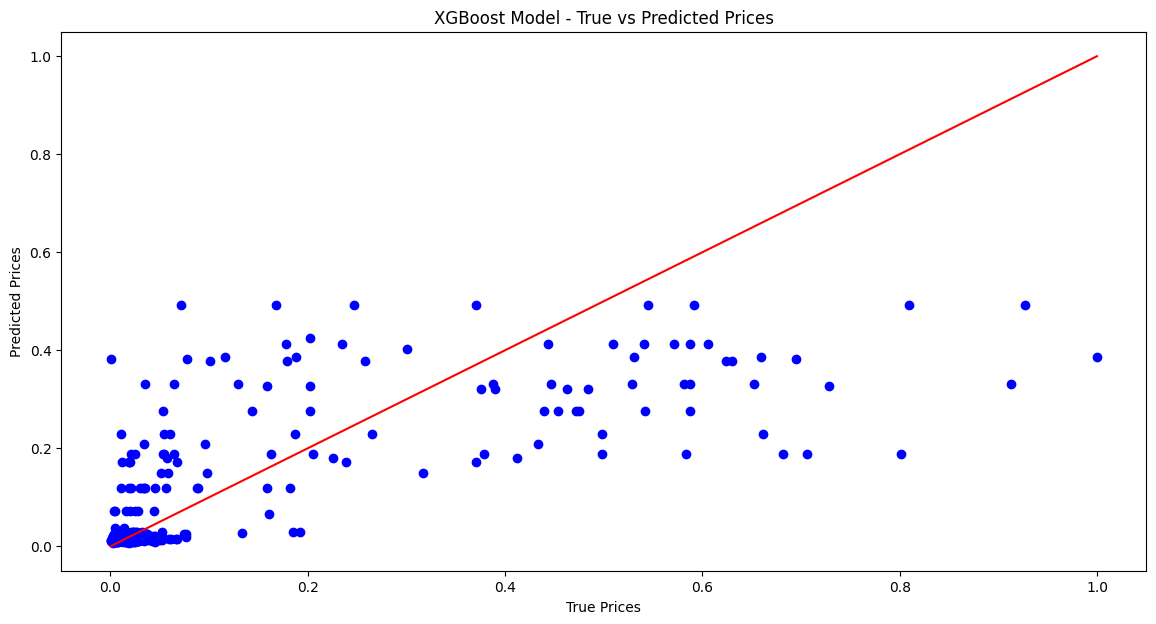

In [ ]:
# 4. XGBoost Predictions for Price
plt.figure(figsize=(14, 7))
plt.scatter(y_test, xgb_predictions, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title('XGBoost Model - True vs Predicted Prices')
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.show()

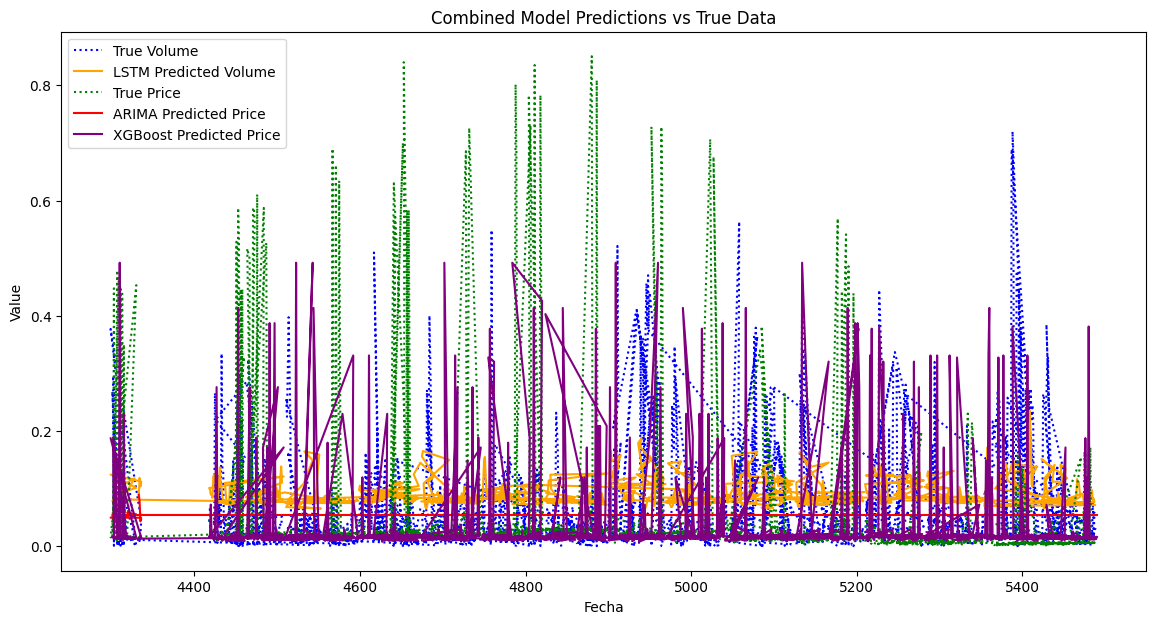

In [ ]:
# 5. Combined Plot for All Predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Volumen'], label='True Volume', color='blue', linestyle='dotted')

# Adjust the x-axis data to match the length of the predicted volume
plt.plot(test.index[:len(scaler.inverse_transform(test_predict.reshape(-1,1)))],
         scaler.inverse_transform(test_predict.reshape(-1,1)),
         label='LSTM Predicted Volume', color='orange')

plt.plot(test.index, test['Precio promedio'], label='True Price', color='green', linestyle='dotted')
plt.plot(test.index, arima_predictions, label='ARIMA Predicted Price', color='red')
plt.plot(test.index, xgb_predictions, label='XGBoost Predicted Price', color='purple')
plt.title('Combined Model Predictions vs True Data')
plt.xlabel('Fecha')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Convert the 'Fecha' column to datetime if not already in datetime format
limon_data['Fecha'] = pd.to_datetime(limon_data['Fecha'])

# Check for any missing values and handle them if necessary
limon_data.isnull().sum()

# Example: Forward fill missing values
limon_data.fillna(method='ffill', inplace=True)

<ipython-input-76-69923f037d3a>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  limon_data.fillna(method='ffill', inplace=True)


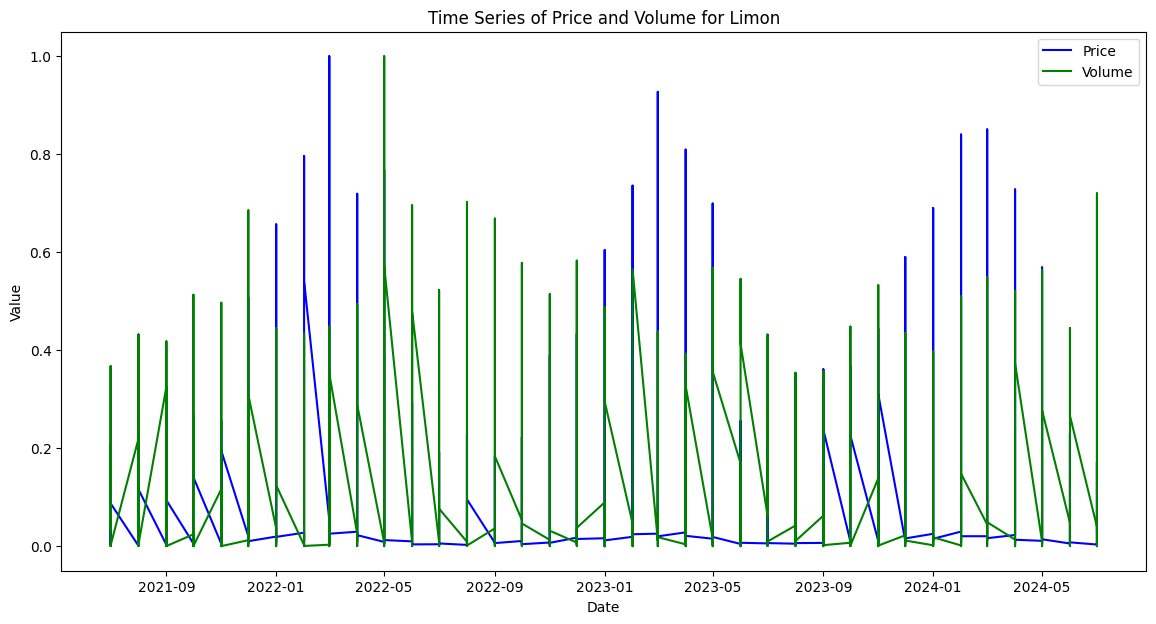

In [ ]:
import matplotlib.pyplot as plt

# Plotting Prices and Volumes over Time
plt.figure(figsize=(14, 7))
plt.plot(limon_data['Fecha'], limon_data['Precio promedio'], label='Price', color='blue')
plt.plot(limon_data['Fecha'], limon_data['Volumen'], label='Volume', color='green')
plt.title('Time Series of Price and Volume for Limon')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

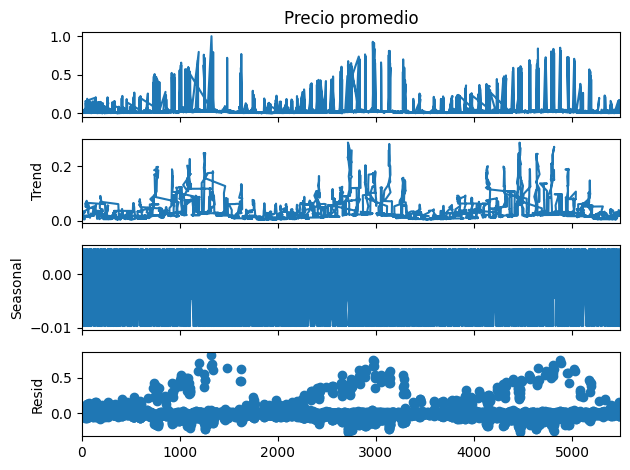

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the series to see trend, seasonality, and residuals
result = seasonal_decompose(limon_data['Precio promedio'], model='additive', period=12)
result.plot()
plt.show()

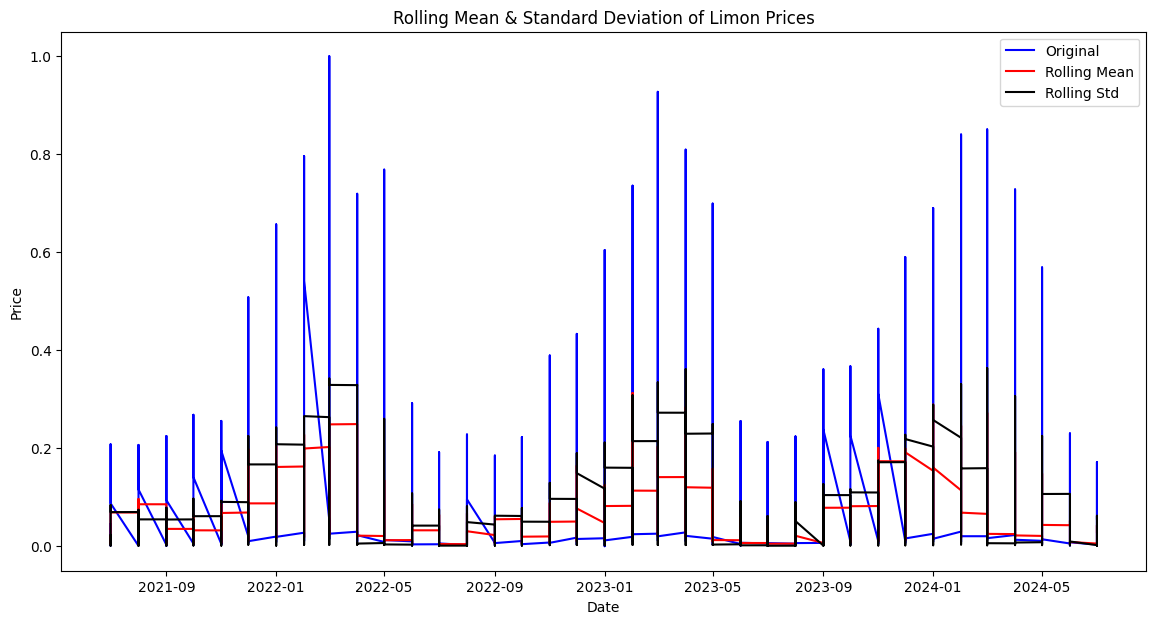

In [ ]:
# Rolling statistics
plt.figure(figsize=(14, 7))
limon_data['Rolling Mean'] = limon_data['Precio promedio'].rolling(window=12).mean()
limon_data['Rolling Std'] = limon_data['Precio promedio'].rolling(window=12).std()

plt.plot(limon_data['Fecha'], limon_data['Precio promedio'], color='blue', label='Original')
plt.plot(limon_data['Fecha'], limon_data['Rolling Mean'], color='red', label='Rolling Mean')
plt.plot(limon_data['Fecha'], limon_data['Rolling Std'], color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation of Limon Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


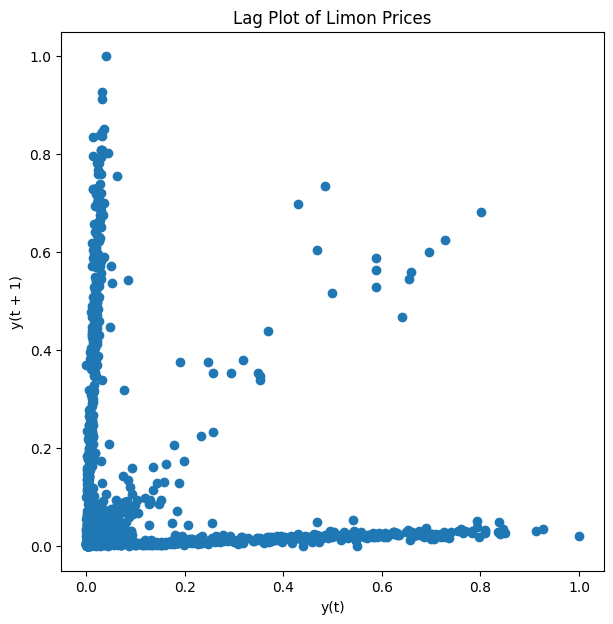

In [ ]:
from pandas.plotting import lag_plot

# Lag plot to check for any autocorrelation
plt.figure(figsize=(7, 7))
lag_plot(limon_data['Precio promedio'])
plt.title('Lag Plot of Limon Prices')
plt.show()

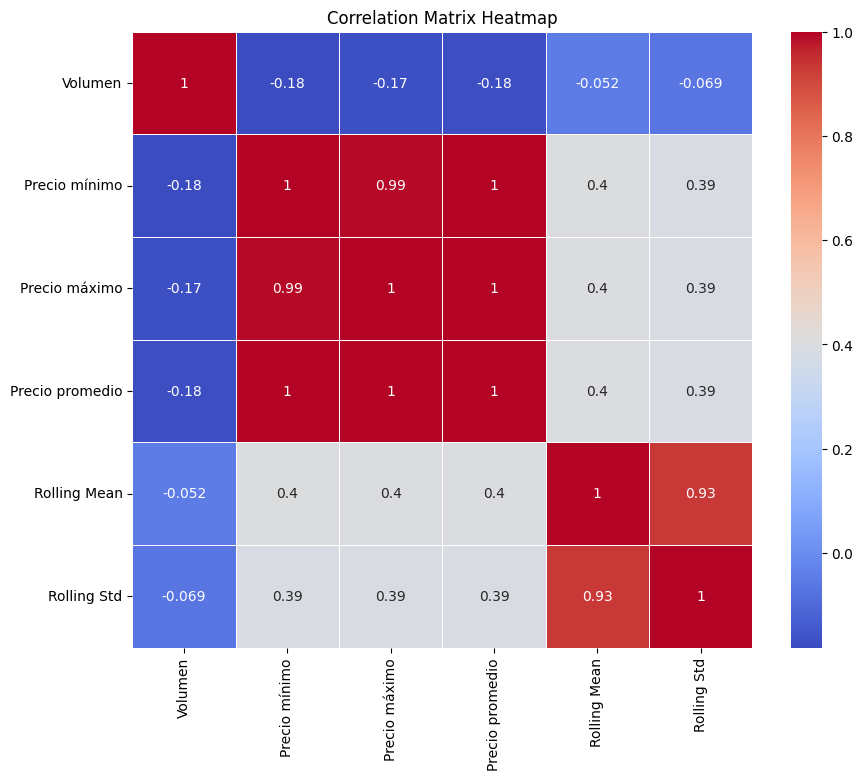

In [ ]:
import seaborn as sns

# Compute the correlation matrix, selecting only numeric columns
corr = limon_data.select_dtypes(include=['number']).corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

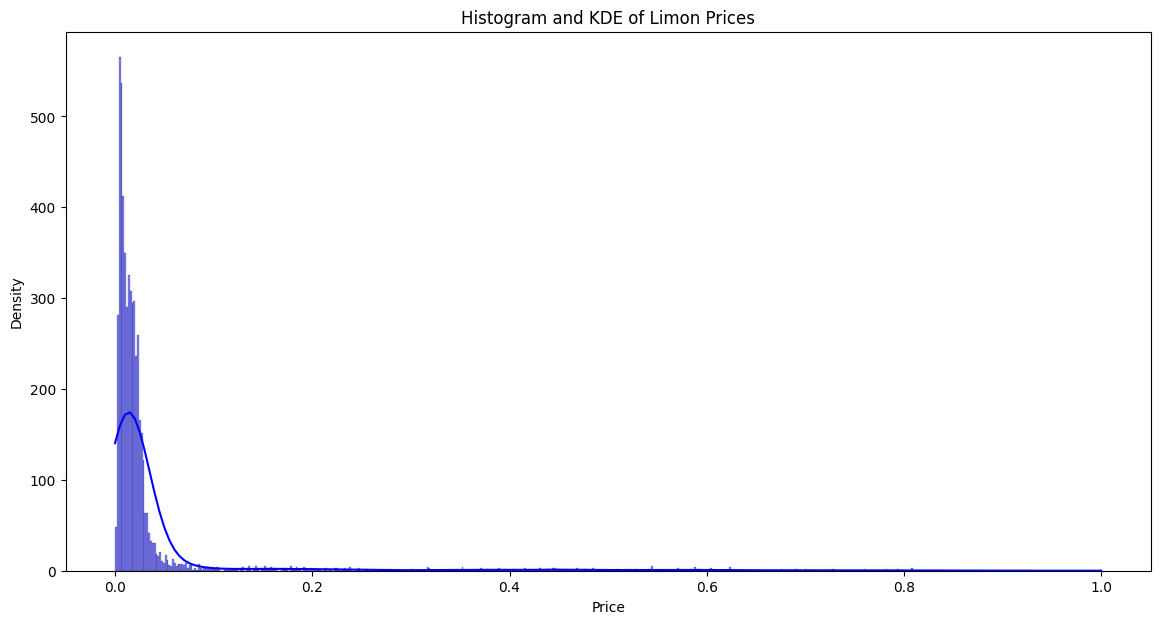

In [ ]:
# Histogram and Kernel Density Estimate (KDE) for Prices
plt.figure(figsize=(14, 7))
sns.histplot(limon_data['Precio promedio'], kde=True, color='blue')
plt.title('Histogram and KDE of Limon Prices')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

<Figure size 1400x700 with 0 Axes>

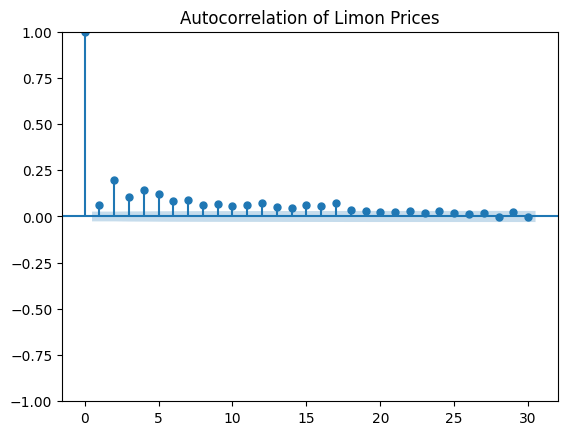

<Figure size 1400x700 with 0 Axes>

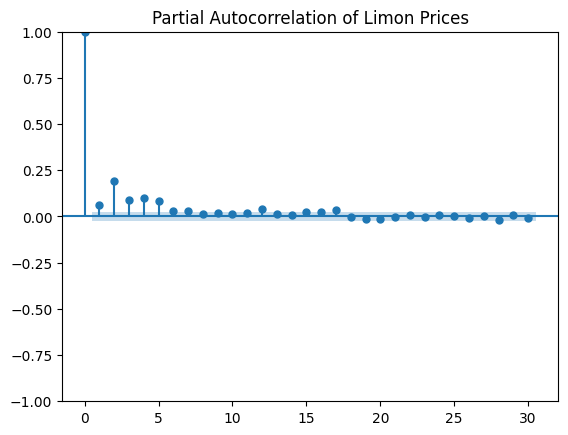

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation plot
plt.figure(figsize=(14, 7))
plot_acf(limon_data['Precio promedio'], lags=30)
plt.title('Autocorrelation of Limon Prices')
plt.show()

# Partial Autocorrelation plot
plt.figure(figsize=(14, 7))
plot_pacf(limon_data['Precio promedio'], lags=30)
plt.title('Partial Autocorrelation of Limon Prices')
plt.show()

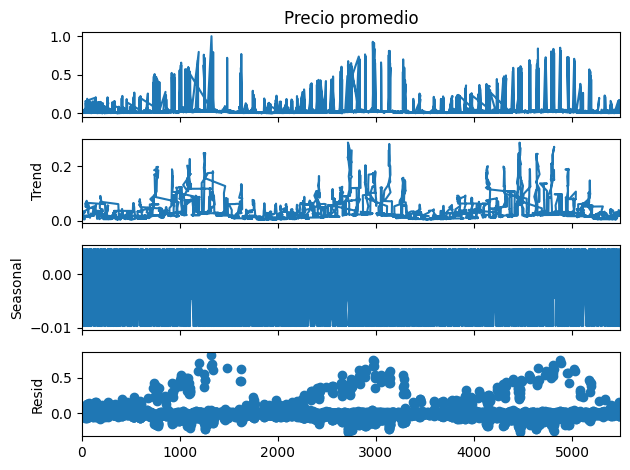

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'limon_data['Precio promedio']' is your time series data
time_series_data = limon_data['Precio promedio']  # Assign the time series data

# Decompose the time series
result = seasonal_decompose(time_series_data, model='additive', period=12) # period could be 12 for monthly data
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the components
result.plot()
plt.show()

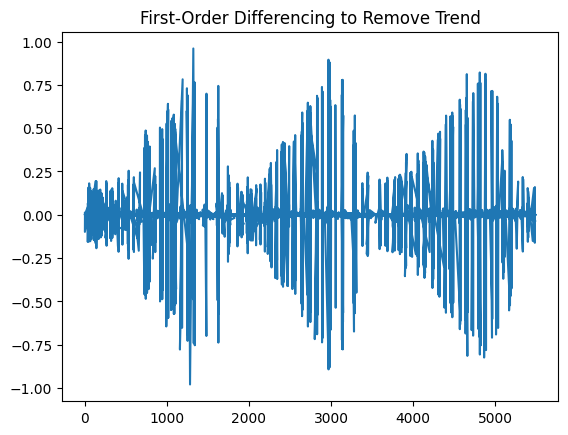

In [ ]:
differenced_series = time_series_data.diff().dropna()

# Plot the differenced series
plt.plot(differenced_series)
plt.title('First-Order Differencing to Remove Trend')
plt.show()


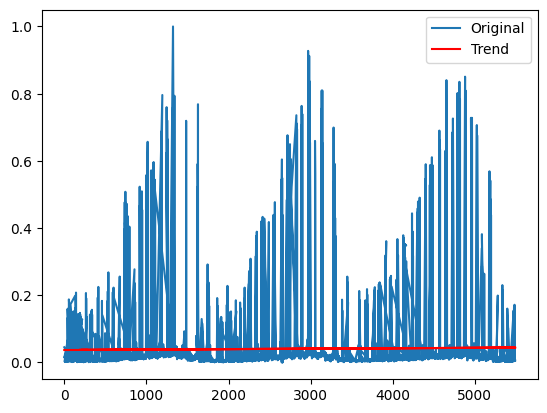

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare the data
X = np.array(range(len(time_series_data))).reshape(-1, 1)
y = time_series_data.values

# Fit the linear model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the trend
plt.plot(time_series_data.index, time_series_data, label='Original')
plt.plot(time_series_data.index, trend, label='Trend', color='red')
plt.legend()
plt.show()


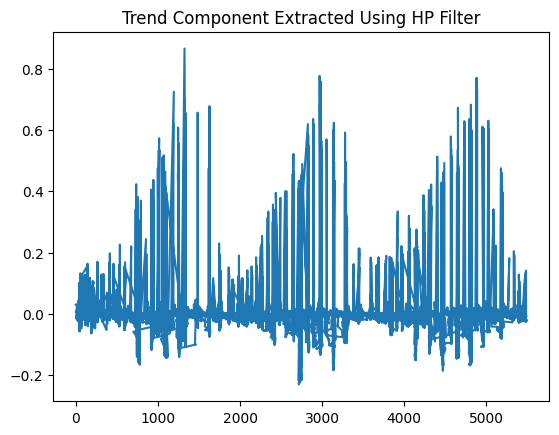

In [ ]:
import statsmodels.api as sm

# Apply HP filter
trend, cycle = sm.tsa.filters.hpfilter(time_series_data, lamb=1600) # lambda is the smoothing parameter

# Plot the trend
plt.plot(trend)
plt.title('Trend Component Extracted Using HP Filter')
plt.show()


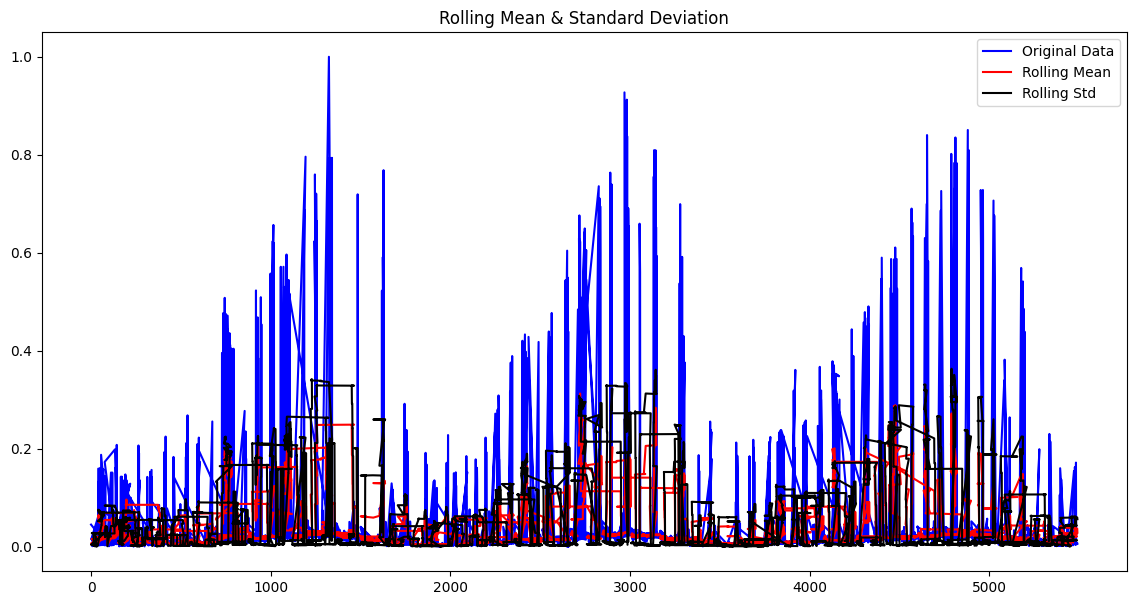

In [ ]:
window = 12  # For example, a 12-month rolling window
rolling_mean = time_series_data.rolling(window=window).mean()
rolling_std = time_series_data.rolling(window=window).std()

plt.figure(figsize=(14, 7))
plt.plot(time_series_data, color='blue', label='Original Data')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()


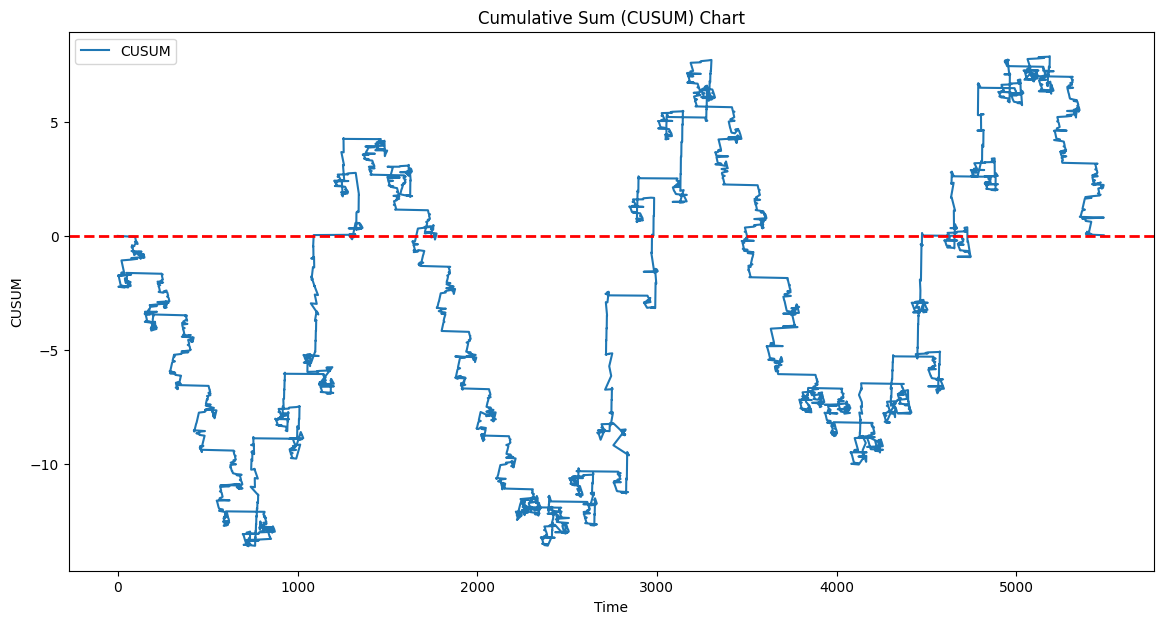

In [ ]:
mean = np.mean(time_series_data)
cusum = np.cumsum(time_series_data - mean)

plt.figure(figsize=(14, 7))
plt.plot(time_series_data.index, cusum, label='CUSUM')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title('Cumulative Sum (CUSUM) Chart')
plt.xlabel('Time')
plt.ylabel('CUSUM')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(time_series_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("The series is stationary, indicating no trend or a stable trend.")
else:
    print("The series is non-stationary, indicating a trend that may or may not be stable.")


ADF Statistic: -12.819819862441584
p-value: 6.187523055801803e-24
The series is stationary, indicating no trend or a stable trend.


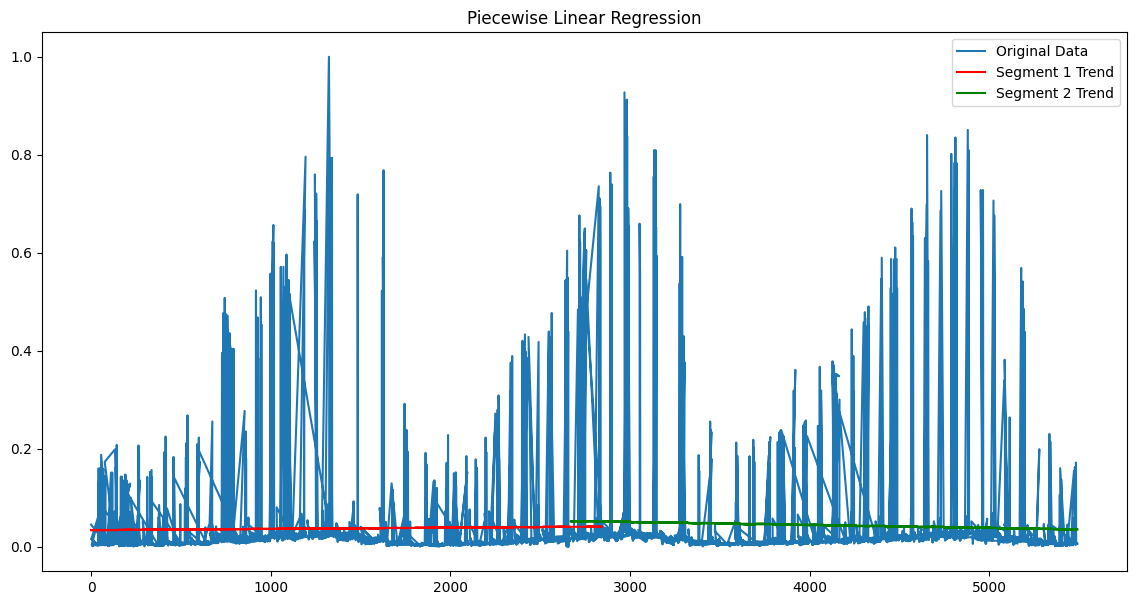

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Split data into two or more segments
mid_point = len(time_series_data) // 2
X1 = np.array(range(mid_point)).reshape(-1, 1)
y1 = time_series_data[:mid_point].values

X2 = np.array(range(mid_point, len(time_series_data))).reshape(-1, 1)
y2 = time_series_data[mid_point:].values

# Fit linear regression on both segments
model1 = LinearRegression().fit(X1, y1)
model2 = LinearRegression().fit(X2, y2)

# Plot the segments and their regression lines
plt.figure(figsize=(14, 7))
plt.plot(time_series_data.index, time_series_data.values, label='Original Data')
plt.plot(time_series_data.index[:mid_point], model1.predict(X1), label='Segment 1 Trend', color='red')
plt.plot(time_series_data.index[mid_point:], model2.predict(X2), label='Segment 2 Trend', color='green')
plt.title('Piecewise Linear Regression')
plt.legend()
plt.show()


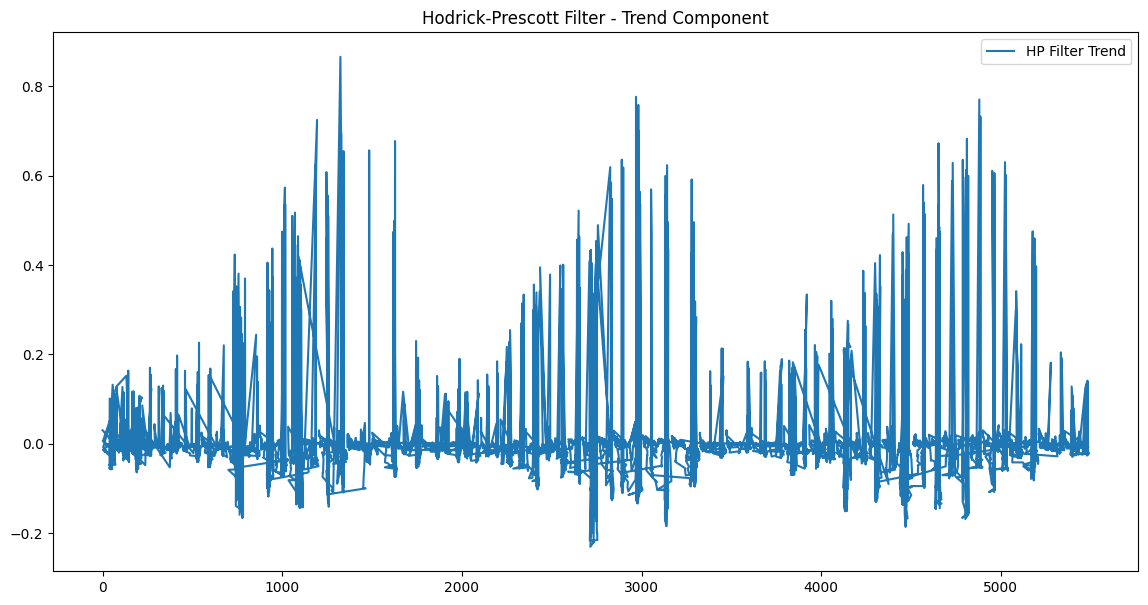

In [ ]:
import statsmodels.api as sm

trend, cycle = sm.tsa.filters.hpfilter(time_series_data, lamb=1600)
plt.figure(figsize=(14, 7))
plt.plot(trend, label='HP Filter Trend')
plt.title('Hodrick-Prescott Filter - Trend Component')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Assuming 'time_series_data' does not have a DatetimeIndex
# Convert the index to DatetimeIndex if it's not already
time_series_data.index = pd.to_datetime(time_series_data.index)  # Adjust format if necessary

# Check if 'backtest_start' exists in the index
if backtest_start in time_series_data.index:
    # Example: Split the data into training and backtesting sets
    train_size = int(len(time_series_data) * 0.8)  # 80% of data for training
    train, test = time_series_data[0:train_size], time_series_data[train_size:]

    # Alternatively, define specific backtesting periods
    # train = time_series_data[:backtest_start]  # Now this should work with DatetimeIndex
    # test = time_series_data[backtest_start:backtest_end]
    # ... rest of your code
else:
    print(f"Error: 'backtest_start' date ({backtest_start}) not found in the index.")
    # Handle the case where the date is not found (e.g., choose a different date)

In [ ]:
# Example: Train an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

MAE: 0.060367493734835326
RMSE: 0.12640807070180715


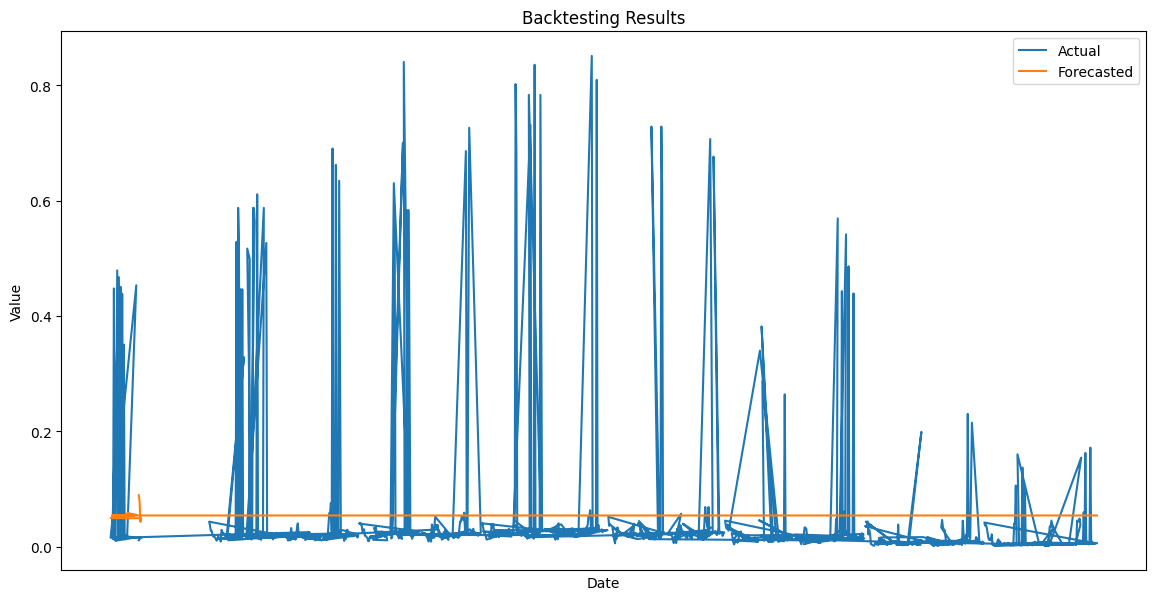

In [ ]:
# Example: Calculate MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecasts)
rmse = np.sqrt(mean_squared_error(test, forecasts))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecasts, label='Forecasted')
plt.title('Backtesting Results')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import re

# Extraer información específica sobre los limones de Pica del texto proporcionado
def extract_pica_lemons_data(text):
    # Buscar todas las coincidencias relacionadas con los limones de Pica
    matches = re.findall(r'(Pica)\s([A-Za-z\s]+)\s(\d+)\s([0-9,]+)\s([0-9,]+)\s([0-9,]+)\s\$/([a-zA-Z\s]+)\s([A-Za-z\s]+)', text)

    # Estructurar la información en un DataFrame
    data = []
    for match in matches:
        region, quality, volume, min_price, max_price, avg_price, unit, source = match
        data.append({
            'Region': region,
            'Quality': quality.strip(),
            'Volume': int(volume.replace(',', '')),
            'Min Price': int(min_price.replace(',', '')),
            'Max Price': int(max_price.replace(',', '')),
            'Avg Price': int(avg_price.replace(',', '')),
            'Unit': unit.strip(),
            'Source': source.strip()
        })

    return pd.DataFrame(data)

# Define the 'text_limon' variable with the relevant text
text_limon = """
# Paste the text containing information about Pica lemons here
"""

# Aplicar la función al texto relevante
pica_lemons_data = extract_pica_lemons_data(text_limon)

# Mostrar los datos extraídos para los limones de Pica
pica_lemons_data

""


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')